In [3]:
import pandas as pd
import numpy as np
import requests, json, re
import requests
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

#options
pd.options.display.max_rows = None
pd.options.display.max_columns = None
pd.options.display.max_colwidth = 30

### Gameplan
- create data cleaning function
    - ID just the stocks( Sector = NaN) **DONE**
    - Remove the Days column, idK what that is **DONE**
    - Create function that transforms the P/L to floats **DONE**
    - Create function that transforms the P/L % to floats **DONE**
    - Take note of available dollars **DONE**
    - Take note of overall P/L YTD **DONE**


- Begin Creating the necessary Fields
    - Market Value **DONE**
    - portfolio weight **DONE**
    - Current date of processing 
    


- Once you have these values, you can aggregate and calculate
- I think in the long run, maybe you should start keeping a system of record 
    - So record the processing date, etc.
    
    
- You also need 3 visuals. Portfolio Trade Value, Market Value, and Delta Value to see what industries are helping vs fking you  **DONE**



### Additional things


- Create a SPY dictionary to compare weightings **DONE**
        - Weightings need to exclude cash positions
        - Maybe figure out how to scrape long term.. for now just table --- yea you should scrape because this changes... especially with tech downturn
        - https://www.spglobal.com/spdji/en/indices/equity/sp-500/#data

- How many stocks in your portfolio? (stock level analysis)**DONE**
- Cummulative amount of portfolio invested (aka non cash) **DONE**
- How does current portfolio composition compare to SPY composition **DONE**

- We need a graph with a horizontal line at the 10% indiciating the max posiiton size for a stock and then the stock % weights... i guess i should have 20 stocks max

In [4]:
# Creating SPY Weighting Dictionary
# Write this to a text file but but later
spy = { 
    'Information Technology': .273,
    'Health Care': .141,
    'Consumer Discretionary':.114,
    'Financials': .109,
    'Communication Services':.084,
    'Industrials':.079,
    'Consumer Staples':.068,
    'Energy':.047,
    'Utilities':.031,
    'Real Estate':.029,
    'Materials':.025
}

In [5]:
#Function to transform P/L values to float 
def pl2str(x):
    if len(re.findall('%',str(x))) > 0: return round(float(re.sub('\$|\)|\,|%','',re.sub('\(','-',str(x))))/100,3)
    else: return float(re.sub('\$|\)|\,|%','',re.sub('\(','-',str(x))))

In [43]:
df = pd.read_csv('2022-10-05-PositionStatement.csv',skiprows = 6)
# Filterning down to the relevant stocks
stocks = df.loc[~df.Sector.isnull() == True, df.columns!='Days'].copy().reset_index()

#Column data type transformations
stocks['Trade Price'] = stocks['Trade Price'].astype(float)
stocks['Mark'] = stocks['Mark'].astype(float)
stocks['Qty'] = stocks['Qty'].astype(float)
stocks['P/L Open'] = [pl2str(x) for x in stocks['P/L Open']]
stocks['P/L %'] = [pl2str(x) for x in stocks['P/L %']]

#Taking in the PL, Available Dollars, and Portfolio value
pl = pl2str(df.loc[df.Instrument == 'OVERALL P/L YTD','Qty'].values[0])
ad = pl2str(df.loc[df.Instrument == 'AVAILABLE DOLLARS','Qty'].values[0])
pv = ad + np.array(stocks['Mark'] * stocks['Qty'] ).sum()

#Trade Value (stock worth at time of trade)
stocks['TV'] = stocks['Trade Price'] * stocks['Qty'] 

#Market Value (stock worth at current price )
stocks['MV'] = stocks['Mark'] * stocks['Qty'] 

#Portfolio Weight
stocks['PW'] = stocks['MV']/stocks['MV'].sum()

#Calulating number of stocks in the portfolio
len(stocks.Instrument.values)
#Calculating cash/stock
cashstock = (ad/pv,1 - ad/pv)
#Calulating portfolio return
preturn = pl/(pv + abs(pl))

In [44]:
cashstock

(0.16689334656295024, 0.8331066534370497)

<AxesSubplot:xlabel='sector'>

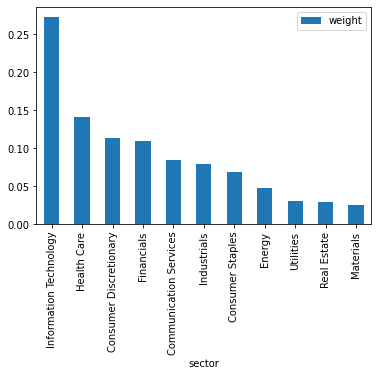

In [8]:
#SPY Weightings
spy2 = pd.DataFrame(spy.items(), columns = ['sector','weight']).set_index('sector')
spy2.plot(kind = 'bar')

<AxesSubplot:xlabel='Sector'>

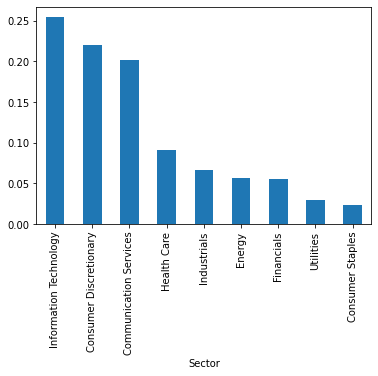

In [9]:
#Just make a 2 level groupby and then I guess select on seperate indexes 
#Order by SPY sectors weights
sectors  = stocks.groupby('Sector')

#Portfolio Weight (NOTE THAT THIS EXCLUDES YOUR CASH POSITION WHICH IS 41%) 
sectors.PW.sum().sort_values(ascending = False).plot(kind = 'bar')

<AxesSubplot:xlabel='sector'>

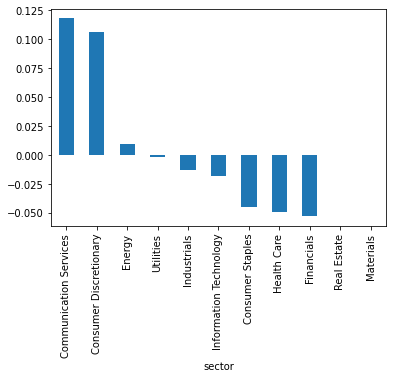

In [10]:
spyVp = spy2.join(pd.DataFrame(sectors.PW.sum()),how = 'left')

spyVp['DeltaWeight'] = spyVp['PW'] - spyVp['weight'] 

spyVp['DeltaWeight'].sort_values(ascending = False).plot(kind = 'bar')
#spyVp['DeltaWeight']

In [11]:
#creating trade value, market value, delta value 
#Note: You can't calculate weights because you don't know the value of your portfolio at T = 0. T = 0 is always 
#changing and you're always entering/exiting positions and (hopefully) adding in money
#Note this also doesn't take into account exited positions... closed gains/losses like NUE or stupid YETI -- this is just for current portfolio stocks 
sectorstv = sectors.TV.sum().sort_values(ascending = False)
sectorsmv = sectors.MV.sum().sort_values(ascending = False)
sectorsdv  = sectorsmv - sectorstv
sectorstv , sectorsmv, sectorsdv

(Sector
 Information Technology    4352.1004
 Consumer Discretionary    4014.1427
 Communication Services    3910.9950
 Health Care               1651.0728
 Industrials               1095.8423
 Financials                 949.8490
 Energy                     808.2670
 Utilities                  487.4056
 Consumer Staples           475.5500
 Name: TV, dtype: float64,
 Sector
 Information Technology    4048.130
 Consumer Discretionary    3506.900
 Communication Services    3212.190
 Health Care               1453.565
 Industrials               1051.820
 Energy                     902.150
 Financials                 889.480
 Utilities                  467.760
 Consumer Staples           366.550
 Name: MV, dtype: float64,
 Sector
 Communication Services   -698.8050
 Consumer Discretionary   -507.2427
 Consumer Staples         -109.0000
 Energy                     93.8830
 Financials                -60.3690
 Health Care              -197.5078
 Industrials               -44.0223
 Information 

### Creating the graphs I want for Dash

- The SPY, Portfolio, Delta view **Done**
- Stocks held with that line across 10% showing nothing should be above 10% (no need for line...) **Done** 

Performance Graphs
 - P/L by Sector (%)
 - P/L by Stock  (%)

In [12]:
#I want to color coordinate

colormap = {'Information Technology':'#BF3F3F',
            'Health Care': '#BF7F3F',
            'Consumer Discretionary': '#BFBF3F',
            'Financials': '#7FBF3F',
            'Communication Services':'#3FBF3F',
            'Industrials': '#3FBF7F',
            'Consumer Staples':'#3FBFBF',
            'Energy':'#3F7FBF',
            'Utilities':'#3F3FBF',
            'Real Estate':'#7F3FBF',
            'Materials': '#BF3FBF'
           }


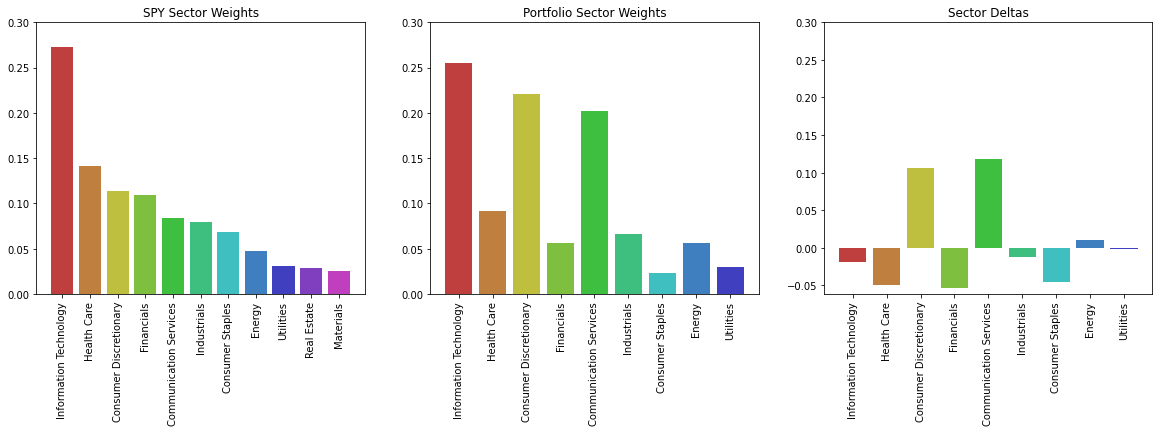

In [38]:
figure = plt.figure(figsize = (20,5))

ax0 = figure.add_subplot(1,3,1)
plt.title('SPY Sector Weights')
plt.bar(spy2.index,spy2.weight, color =[colormap.get(x) for x in spy2.index] )
plt.xticks(rotation = 90)
#spy2.plot(kind = 'bar',ax = ax0, color = [colormap.get(x) for x in list(spy2.index)] )
ax0.set_yticks(np.arange(0.0,.35,.05))

ax1 = figure.add_subplot(1,3,2)
my_sectors = sectors.PW.sum()[[x for x in spy2.index if x in sectors.PW.sum().index]]
plt.title('Portfolio Sector Weights')
plt.bar(my_sectors.index,my_sectors.values, color =[colormap.get(x) for x in my_sectors.index] )
plt.xticks(rotation = 90)
ax1.set_yticks(np.arange(0.0,.35,.05))

#sectors.PW.sum()[[x for x in spy2.index if x in sectors.PW.sum().index]].plot(kind = 'bar',ax = ax1)


ax2 = figure.add_subplot(1,3,3)
sector_delta = spyVp['DeltaWeight'][[x for x in spy2.index if x in sectors.PW.sum().index]]
plt.title('Sector Deltas')
plt.bar(sector_delta.index,sector_delta.values, color =[colormap.get(x) for x in sector_delta.index] )
plt.xticks(rotation = 90)
ax2.set_yticks(np.arange(-0.05,.35,.05))

plt.show()

In [35]:
#my_sectors.index[-2] = 'Materials'
my_sectors = my_sectors.rename({'Energy':'Materials'})
my_sectors

Sector
Information Technology    0.254623
Health Care               0.091428
Consumer Discretionary    0.220580
Financials                0.055947
Communication Services    0.202043
Industrials               0.066158
Consumer Staples          0.023056
Materials                 0.056744
Utilities                 0.029422
Name: PW, dtype: float64

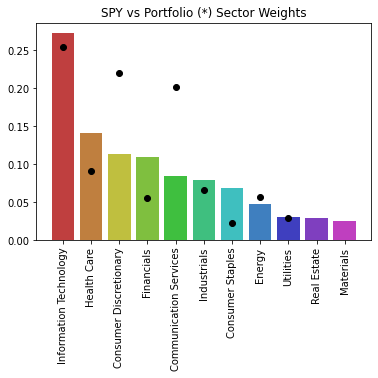

In [40]:
# SPY Sector weights (bar) vs Portfolio Sector Weights (dots)
plt.title('SPY vs Portfolio (*) Sector Weights')
plt.bar(spy2.index,spy2.weight, color =[colormap.get(x) for x in spy2.index] )
plt.scatter(my_sectors.index,my_sectors.values, color = 'black')
plt.xticks(rotation = 90)
#spy2.plot(kind = 'bar',ax = ax0, color = [colormap.get(x) for x in list(spy2.index)] )
#plt.set_yticks(np.arange(0.0,.35,.05))
plt.show()




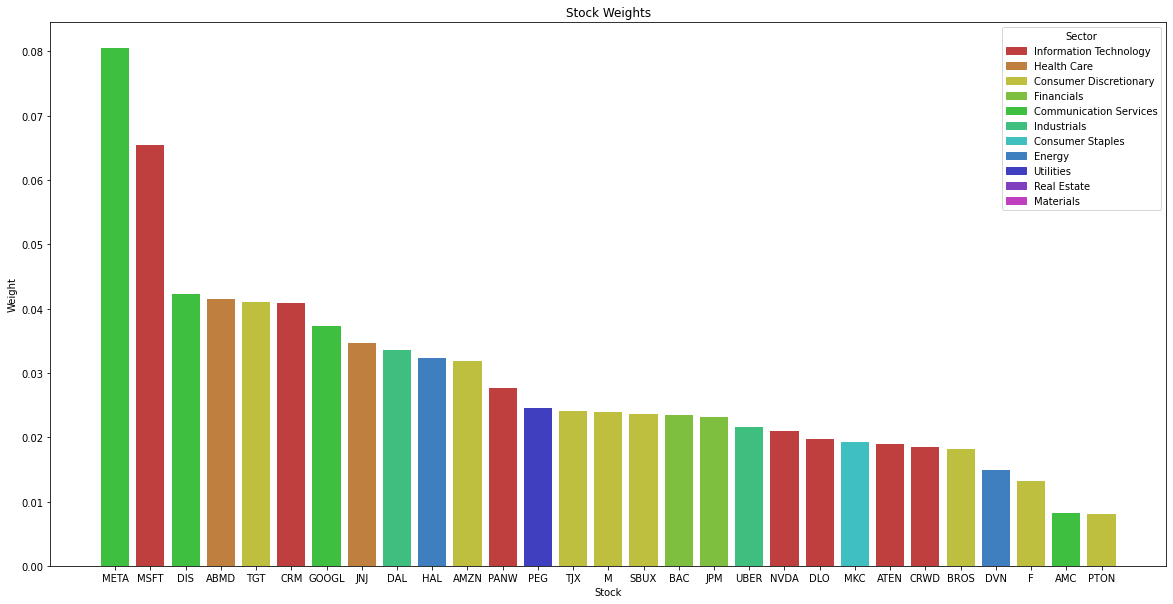

In [14]:
#Stock weight but including cash in the denominator. 
#Research what patch is
from matplotlib.patches import Patch



stock_weights = pd.DataFrame({'Stock':stocks['Instrument'],
                              'Weight':[x/(stocks['MV'].sum() + ad) for x in stocks['MV']],
                              'Sector': stocks['Sector']
                             }).sort_values(by = 'Weight',ascending = False)

# create the rectangles for the legend
patches = [Patch(color=v, label=k) for k, v in colormap.items()]


plt.figure(figsize=(20, 10))
plt.bar(stock_weights['Stock'],stock_weights['Weight'], color =[colormap.get(x) for x in stock_weights['Sector']] )
plt.title('Stock Weights')
plt.xlabel('Stock')
plt.ylabel('Weight')
plt.legend(title='Sector', 
           labels=list(colormap.keys()), 
           handles=patches
          )

plt.show()

In [15]:
dv_frame = pd.DataFrame({'Sector': list(sectorsdv.index),
                         'Loss': sectorsdv.values,
                         'PLoss': sectorsdv/(sectorsmv + sectorsdv)
                        }).set_index('Sector')
                        
dv_frame

,Loss,PLoss
Sector,,
Communication Services,-698.8050,-0.278033
Consumer Discretionary,-507.2427,-0.169100
Consumer Staples,-109.0000,-0.423219
Energy,93.8830,0.094257
Financials,-60.3690,-0.072812
Health Care,-197.5078,-0.157244
Industrials,-44.0223,-0.043682
Information Technology,-303.9704,-0.081185
Utilities,-19.6456,-0.043841


In [16]:
dv_frame.loc[sectorsmv.index]

,Loss,PLoss
Sector,,
Information Technology,-303.9704,-0.081185
Consumer Discretionary,-507.2427,-0.169100
Communication Services,-698.8050,-0.278033
Health Care,-197.5078,-0.157244
Industrials,-44.0223,-0.043682
Energy,93.8830,0.094257
Financials,-60.3690,-0.072812
Utilities,-19.6456,-0.043841
Consumer Staples,-109.0000,-0.423219


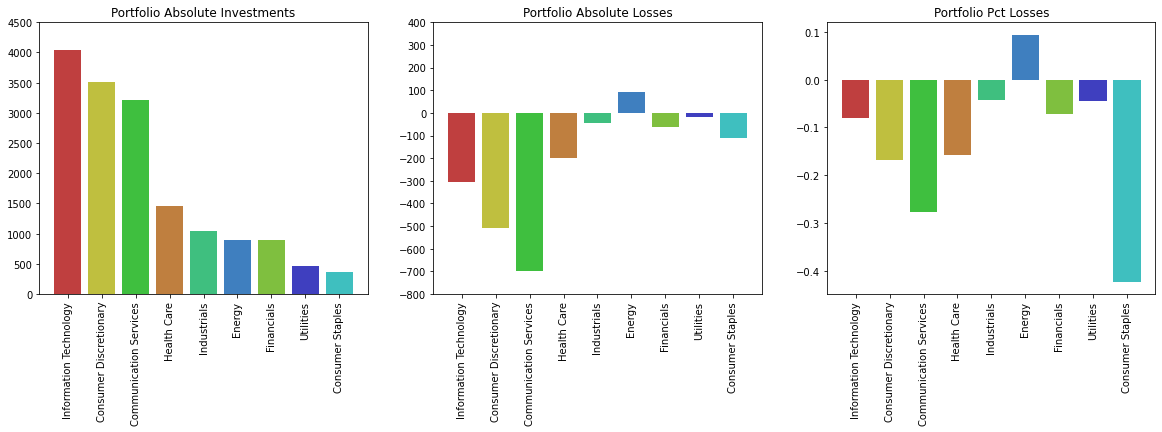

In [17]:
# Graph Showing P/L by Sector (Show absolute values --> graphs 1 & 2, Show % values --> graph 3  ) 
# Graph Showing P/L by Stock (Contribution to total Portfolio P/L) 


figure = plt.figure(figsize = (20,5))

ax0 = figure.add_subplot(1,3,1)
plt.title('Portfolio Absolute Investments')
plt.bar(sectorsmv.index,sectorsmv.values, color =[colormap.get(x) for x in sectorsmv.index] )
plt.xticks(rotation = 90)
ax0.set_yticks(np.arange(0.0,5000,500))


dv_frame = pd.DataFrame({'Sector': list(sectorsdv.index),
                         'Loss': sectorsdv.values,
                         'PLoss': sectorsdv/(sectorsmv + sectorsdv)
                        }).set_index('Sector')
                        
                         
                         
ax1 = figure.add_subplot(1,3,2)
plt.title('Portfolio Absolute Losses')
plt.bar(dv_frame.loc[sectorsmv.index].index,dv_frame.loc[sectorsmv.index].Loss, color =[colormap.get(x) for x in dv_frame.loc[sectorsmv.index].index] )
plt.xticks(rotation = 90)
ax1.set_yticks(np.arange(-800,500,100))

ax2 = figure.add_subplot(1,3,3)
sector_delta = spyVp['DeltaWeight'][[x for x in spy2.index if x in sectors.PW.sum().index]]
plt.title('Portfolio Pct Losses')
plt.bar(dv_frame.loc[sectorsmv.index].index,dv_frame.loc[sectorsmv.index].PLoss, color =[colormap.get(x) for x in dv_frame.loc[sectorsmv.index].index] )
plt.xticks(rotation = 90)
#ax2.set_yticks(np.arange(-0.05,.35,.05))

plt.show()



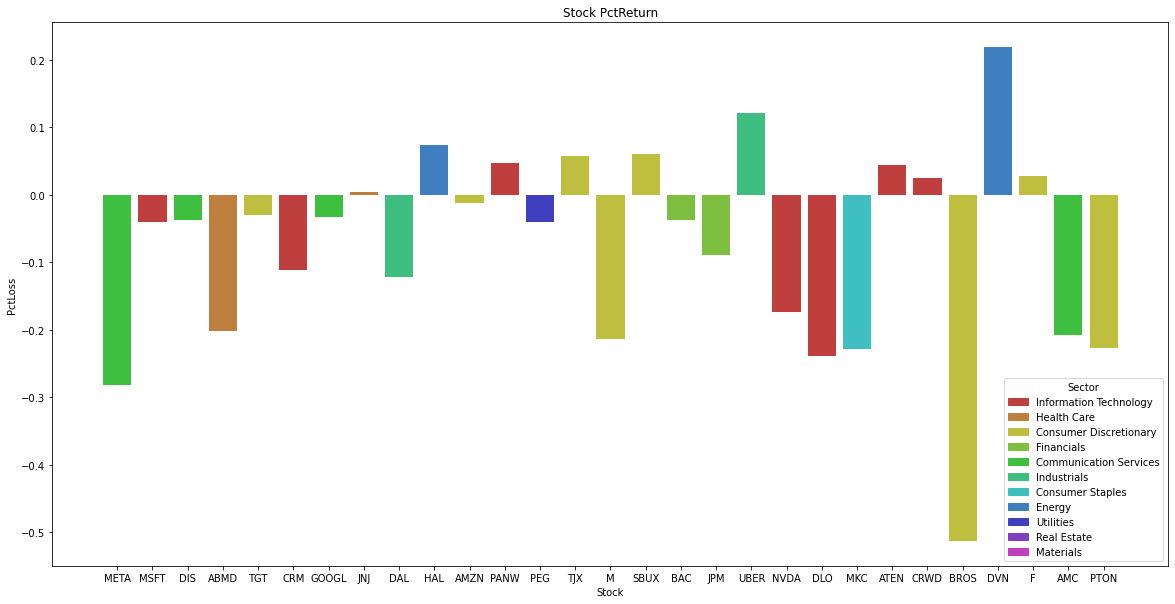

In [18]:
#Stock weight but including cash in the denominator. 
#Research what patch is
from matplotlib.patches import Patch



stock_pctreturn = pd.DataFrame({'Stock':stocks['Instrument'],
                              'PctLoss':(stocks['MV'] - stocks['TV'])/ stocks['TV'],
                              'Sector': stocks['Sector']
                             }).sort_values(by = 'PctLoss',ascending = False)

# create the rectangles for the legend
patches = [Patch(color=v, label=k) for k, v in colormap.items()]


plt.figure(figsize=(20, 10))
plt.bar(stock_pctreturn.loc[list(stock_weights.index),'Stock'],stock_pctreturn.loc[list(stock_weights.index),'PctLoss'], 
        color =[colormap.get(x) for x in stock_pctreturn.loc[list(stock_weights.index),'Sector']] )
plt.title('Stock PctReturn')
plt.xlabel('Stock')
plt.ylabel('PctLoss')
plt.legend(title='Sector', 
           labels=list(colormap.keys()), 
           handles=patches
          )

plt.show()